# Grover implementation in qiskit

Qiskit provides some Grover oracles for you to use for implementing Grover's algorithm. Let's use one of those and test the algorithm to find the marked element. 

Note: in order to use the oracle you need the qiskit-textbook module which you can find [here](https://github.com/qiskit-community/qiskit-textbook).

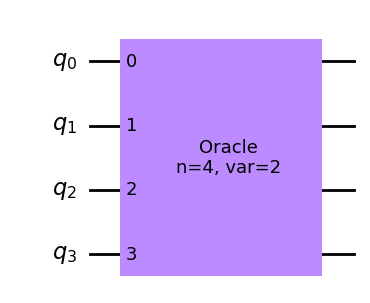

In [1]:
from qiskit_textbook.problems import grover_problem_oracle
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import *

## Example usage of the oracle
nqubits = 4
oracle = grover_problem_oracle(nqubits, variant=2)  # Has 1 solution
oracle = oracle.to_gate()
qc = QuantumCircuit(nqubits)
qc.append(oracle, [0,1,2,3])
qc.draw(output='mpl') # Need to install pylatexenc for this but prints nicer

One method to build the quantum circuit is to define the Grover iterate and then repeatedly apply it. To do this we first need to define the second gate that goes into the Grover iterate 
$$
R = 2|s \rangle \langle s|-I = H^{\otimes n} (2 |0\rangle\langle 0| - I) H^{\otimes n}\,.
$$

But how do we build this "diffuser"?

Well we could consider a related problem. Define a unitary $U$ that maps 
$$
U|x\rangle= \begin{cases} -|1^n\rangle \quad &\text{if }|x\rangle = |1^n\rangle \\ 
|x\rangle \quad &\text{otherwise}.
\end{cases}
$$

This unitary has a relatively straightforward implementation. It is a controlled $Z$ operator where we control on $n-1$ qubits. I.e., the $Z$ is applied to the remaining qubit only when all other qubits are in the state $1$ and so it applies a phase only to the all 1 string. We can modify this to what we want by padding this unitary with the bitflip $X$ operators.

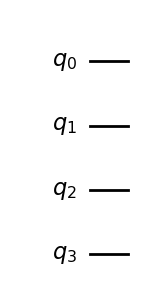

In [2]:
R_circuit = QuantumCircuit(nqubits)
#############################################
# Add some code  BELOW HERE to build the circuit corresponding to the R gate
# Tip: You can do everything with


##################################################
R_gate = R_circuit.to_gate(label='R gate')
R_circuit.draw('mpl')

### The grover iterate

Now that we have the $R$ gate let's make the Grover iterate.

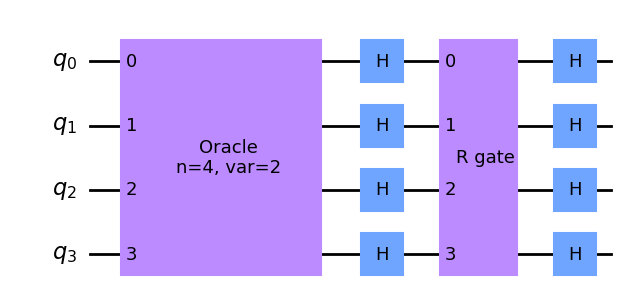

In [3]:
iterate_circuit = QuantumCircuit(nqubits)

# Apply the oracle 
iterate_circuit.append(oracle, list(range(nqubits)))

# Apply the Hadamards
for i in range(nqubits):
    iterate_circuit.h(i)
    
# Apply the R gate
iterate_circuit.append(R_gate, list(range(nqubits)))

# Apply Hadamards again 
for i in range(nqubits):
    iterate_circuit.h(i)
    
iterate = iterate_circuit.to_gate()
iterate_circuit.draw('mpl')
    

## Putting it all together

Now we have the iterate it is quite easy to finish off the circuit and test whats going on. It is interesting to check how the probability distribution changes when we change the number of times we apply the iterate as well so let's check this by building many circuits with different numbers of repetitions for the iterate.  

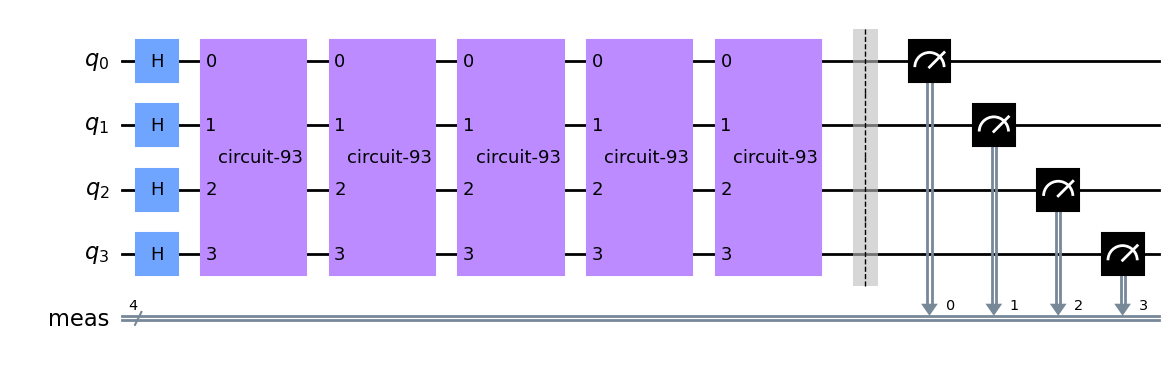

In [4]:
# Build a list of circuits whose index gives the number of times the iterate is applied
ncircuits = 8
grover_circuits = [QuantumCircuit(nqubits) for _ in range(ncircuits)]

# now we build each circuit
for k in range(ncircuits):
    # Apply the initial Hadamards
    for i in range(nqubits):
        grover_circuits[k].h(i)
    # Apply the iterate k times
    for j in range(k):
        grover_circuits[k].append(iterate, list(range(nqubits)))
    # Finally do the measurements
    grover_circuits[k].measure_all()
    
# Can check it has worked
grover_circuits[5].draw('mpl')

In [7]:
# Now let's run the circuits on a simulator
backend = Aer.get_backend("qasm_simulator")

# run each of the circuits
results = [execute(grover_circuits[k], backend, shots=1024).result() for k in range(ncircuits)]
counts = [result.get_counts() for result in results]
histograms = [plot_histogram(count) for count in counts]

In [12]:
for k in range(ncircuits):
    histograms[k].savefig('grover_result_' + str(k) + '.jpg')

**0 iterates** ![](grover_result_0.jpg)
**1 iterates** ![](grover_result_1.jpg)
**2 iterates** ![](grover_result_2.jpg)
**3 iterates** ![](grover_result_3.jpg)
**4 iterates** ![](grover_result_4.jpg)
**5 iterates** ![](grover_result_5.jpg)
**6 iterates** ![](grover_result_6.jpg)
**7 iterates** ![](grover_result_7.jpg)

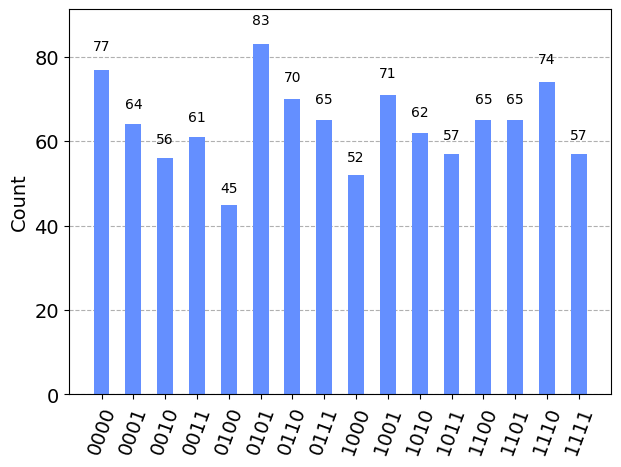

In [11]:
histograms[3]